# Treinamento com interface de alto nível

O objetivo deste notebook é ilustrar o uso da biblioteca `pytorch_trainer` que permite uma programação de mais alto nível.

Os conceitos importantes são:
- classe DeepNetTrainer:
    - responsável pelo treinamento com praticamente todas as opções possíveis
    - uso de 8 entry points para uso de callbacks:
        - início de treinamento
            - início de época
                - início de minibatch de treinamento
                - final de minibatch de treinamento
                - início de minibatch de validação
                - final de minibatch de validação
            - final de época
        - final de treinamento
- classe Callback
    - permite a implementação de vários callbacks úteis:
        - AccuracyMetric: cálculo da acurácia
        - PrintCallback:  impressão das métricas durante treinamento
        - ModelCheckpoint:salva modelo sempre que loss de validação é melhor

## Importação das bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn

import torchvision

import lib.pytorch_trainer as ptt

## Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos 500 amostras de treinamento e 100 amostras de validação.

In [2]:
dataset_dir = '/data/datasets/MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')
x_test,  y_test  = torch.load(dataset_dir + 'processed/test.pt')

x_train = x_train.float()
x_test  = x_test.float()

x_train = x_train / 255.
x_test  = x_test  / 255.

if True:
    n_samples_train = 1000
    n_samples_test  = 500

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]
    x_test  = x_test[:n_samples_test]
    y_test  = y_test[:n_samples_test]

## Visualizando os dados

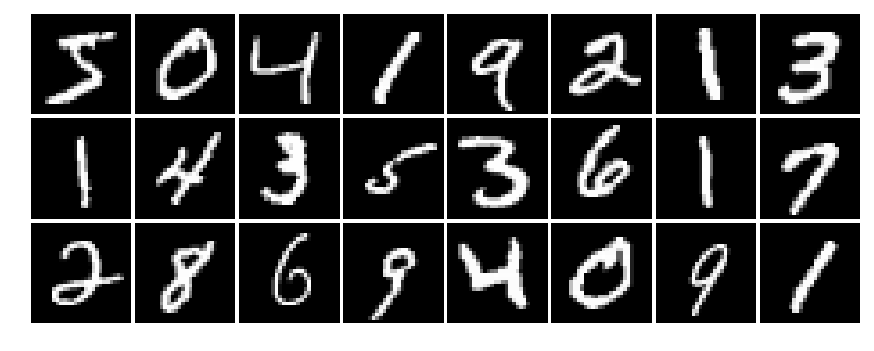

In [3]:
N = 24
grid = torchvision.utils.make_grid(x_train[:N].unsqueeze(1), normalize=True, pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Criação da rede

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 50)
        self.at1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.at1(x)
        x = self.fc2(x)
        return x
    
model = Model()
model

Model (
  (fc1): Linear (784 -> 50)
  (at1): ReLU ()
  (fc2): Linear (50 -> 10)
)

## Treinamento

In [5]:
chkpt_cb = ptt.ModelCheckpoint('../../models/MNIST_neuralnet', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model,
                        criterion = nn.CrossEntropyLoss(),
                        optimizer = torch.optim.SGD(model.parameters(),lr=0.03),
                        callbacks = [chkpt_cb, ptt.AccuracyMetric(),ptt.PrintCallback()]
                        )

In [6]:
trainer.fit(20, x_train, y_train, valid_data=(x_test, y_test))

Start training for 20 epochs
  1:   0.2s   T: 2.03113 0.43100   V: 1.72131 0.56400 best
  2:   0.1s   T: 1.22017 0.73100   V: 1.05954 0.74800 best
  3:   0.1s   T: 0.75417 0.82200   V: 0.78397 0.79000 best
  4:   0.1s   T: 0.56308 0.85600   V: 0.65842 0.83400 best
  5:   0.1s   T: 0.46332 0.87600   V: 0.59577 0.81800 best
  6:   0.1s   T: 0.39802 0.89100   V: 0.53827 0.83000 best
  7:   0.1s   T: 0.35192 0.90300   V: 0.50311 0.84600 best
  8:   0.1s   T: 0.31841 0.90700   V: 0.47710 0.85600 best
  9:   0.1s   T: 0.28743 0.92200   V: 0.46667 0.86000 best
 10:   0.1s   T: 0.25994 0.92600   V: 0.48747 0.83200 
 11:   0.1s   T: 0.24038 0.94100   V: 0.46175 0.84600 best
 12:   0.1s   T: 0.22210 0.94800   V: 0.44081 0.85400 best
 13:   0.1s   T: 0.20354 0.94800   V: 0.44446 0.86000 
 14:   0.1s   T: 0.18834 0.95100   V: 0.42489 0.86000 best
 15:   0.1s   T: 0.17375 0.95800   V: 0.43602 0.85800 
 16:   0.1s   T: 0.16264 0.96400   V: 0.42219 0.85600 best
 17:   0.1s   T: 0.14913 0.96500   V: 0

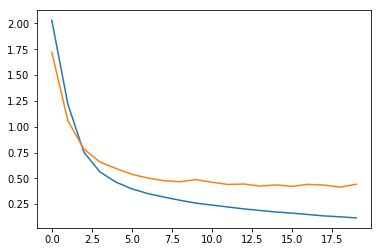

In [7]:
histo_loss_val = trainer.metrics['valid']['losses']
histo_loss_tra = trainer.metrics['train']['losses']
epochs = np.arange(len(histo_loss_val))
plt.plot(epochs,histo_loss_tra, epochs,histo_loss_val)

## Avaliando a acurácia tanto no conjunto de treinamento como no conjunto de validação

### Recuperando o modelo da melhor época

In [8]:
trainer.load_state('../../models/MNIST_neuralnet')

In [9]:
acc_train = trainer.evaluate(x_train,y_train, metrics=[ptt.AccuracyMetric()])
acc_val = trainer.evaluate(x_test,y_test, metrics=[ptt.AccuracyMetric()])

evaluate: 99/99 ok
evaluate: 49/49 ok


In [10]:
print('Training Accuracy:   {:f}'.format(acc_train['acc']))
print('Validation Accuracy: {:f}'.format(acc_val['acc']))

Training Accuracy:   0.987000
Validation Accuracy: 0.852000


## Matriz de confusão com dados de treinamento e validação

In [11]:
y_pred = torch.max(trainer.predict(x_train),1)[1]

In [12]:
pd.crosstab(y_pred.cpu().numpy(),y_train.cpu().numpy())

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,97,0,0,0,0,0,0,0,0,1
1,0,114,0,0,0,0,0,0,0,0
2,0,0,97,0,0,1,0,0,0,0
3,0,0,0,92,0,0,0,0,0,0
4,0,0,0,0,105,1,0,0,0,0
5,0,0,0,1,0,89,0,0,0,1
6,0,0,0,0,0,1,94,0,0,0
7,0,0,0,0,0,0,0,117,0,2
8,0,2,1,0,0,0,0,0,87,1


In [13]:
y_val_pred = torch.max(trainer.predict(x_test),1)[1]

In [14]:
pd.crosstab(y_val_pred.cpu().numpy(),y_test.cpu().numpy())

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,42,0,0,0,0,1,1,0,1,0
1,0,67,1,0,0,1,0,0,0,0
2,0,0,46,1,0,0,1,4,0,0
3,0,0,1,36,0,0,0,4,0,3
4,0,0,1,0,49,0,2,1,1,0
5,0,0,0,7,0,36,3,0,2,2
6,0,0,1,0,2,3,36,0,0,0
7,0,0,3,1,0,3,0,38,2,4
8,0,0,2,0,0,5,0,0,32,1


## Exercícios
1. Implemente e teste uma classe de callback para imprimir o número do miniback e o número da época durante o treinamento.
2. Implemente e teste uma classe de callback para imprimir o valor médio e a variância dos pesos da primeira camada da rede à medida que ela é treinada.

## Aprendizados